## Linear Regression: Ames Housing Price Predictions
#### January 2020

---

<B>Context:</B>
Kaggle competition with the objective of developing a model to predict housing prices in Ames Iowa based on historical data.  Over 100+ DSI students across the nation participated.  This model achieved a ranking within the top 15 based on RMSE and is valid for price predictions.

<B>Key Objectives:</B>
Create model to predict housing prices based on historical data
Evaluate model
Disseminate techniques and methods to technical audience and colleagues

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('./datasets/train.csv', skipinitialspace=True)
test = pd.read_csv('./datasets/test.csv',skipinitialspace=True)

In [3]:
t_id = test.Id
t_id.head()

0    2658
1    2718
2    2414
3    1989
4     625
Name: Id, dtype: int64

In [4]:
train_interim = train.copy()
test_interim = test.copy()

In [5]:
# create a list of possible dummy columns from combined train/test dataset.
# Once we have a list of columns we can add it later.

test_interim['is_test_row'] = 1
train_interim.shape, test_interim.shape

((2051, 81), (878, 81))

In [6]:
mega = pd.DataFrame()
mega = pd.concat([train_interim,test_interim],sort=False)

In [7]:
# add indicators for whether this is a row from Test csv or not
mega['is_test_row'].replace(np.nan,0,inplace=True)

In [8]:
mega.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,is_test_row
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,130500.0,0.0
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,220000.0,0.0


In [9]:
# Drop irrelevant rows

mega.drop(['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'],axis=1, inplace=True)

In [10]:
# Get Dummy Columns and store in a different place for now.

dummy_store1 = pd.get_dummies(mega.copy())

In [11]:
# make a list of original columns, then drop those
list1 = list(mega.columns)
list2 = list(dummy_store1.columns)

In [12]:
len(list2)

282

In [13]:
# remove non-dummy items

for i in list2.copy():
    if i in list1:
        list2.remove(i)
        
        
# resource used:
    # https://stackoverflow.com/questions/18194968/python-remove-duplicates-from-2-lists

In [14]:
len(list2)

242

In [15]:
missing_dummy_list = list(list2)

In [16]:
# OK I have a list of the dummies that will be missing, phew

In [17]:
# Start cleansing process and Identify missing values in train dataset and sort

(train.isna().sum()).sort_values(ascending=False).head(30)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
BsmtFin SF 2         1
Total Bsmt SF        1
BsmtFin SF 1         1
Overall Cond         0
Exterior 2nd         0
Exterior 1st         0
Roof Matl            0
dtype: int64

In [18]:
train2 = pd.DataFrame()
train2 = train

##### Since we have a total of 2051 rows, any field with 1000+ missing values won't be helpful.
##### Therefore I will drop these.

In [19]:
train2.drop(train2[['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu']],axis=1, inplace=True)

In [20]:
# Checking to ensure they've been removed
train2.isna().sum().sort_values(ascending=False).head()

Lot Frontage     330
Garage Yr Blt    114
Garage Finish    114
Garage Qual      114
Garage Cond      114
dtype: int64

In [21]:
train2['Lot Frontage'].mean(), train2['Garage Yr Blt'].mean(), train2['Mas Vnr Area'].mean()

(69.05520046484602, 1978.7077955601446, 99.69590931493346)

In [22]:
train2['SalePrice'].fillna(0,inplace=True)
train2['Lot Frontage'].fillna(69,inplace=True)
train2['Garage Yr Blt'].fillna(1978,inplace=True)
train2['Mas Vnr Area'].fillna(104,inplace=True)

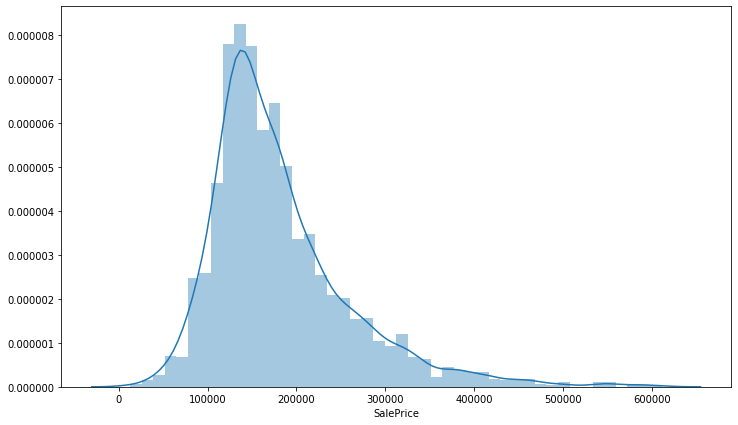

In [23]:
plt.figure(figsize = (12,7))
sns.distplot(train2['SalePrice'])

##### Not exactly normal distribution...right skewed
##### This means data has slightly more data concentration of lower priced houses
##### Most ML algorithms work great with Normally distributed data

In [24]:
# Identifying Numerical columns

numeric_data = train2.select_dtypes(include = [np.number])

# Identifying String columns

string_data = train2.select_dtypes(exclude = [np.number])

In [25]:
# print results

l = format(numeric_data.shape[1]) # store numeric in a variable
z = format(string_data.shape[1]) # store string col count in variable

In [26]:
print(f'There are {l} numeric and {z} columns in the training dataset')

There are 39 numeric and 37 columns in the training dataset


In [27]:
# Add age column

train2['age'] = train2['Yr Sold'] - train2['Year Built']

In [28]:
# total columns
39+37

76

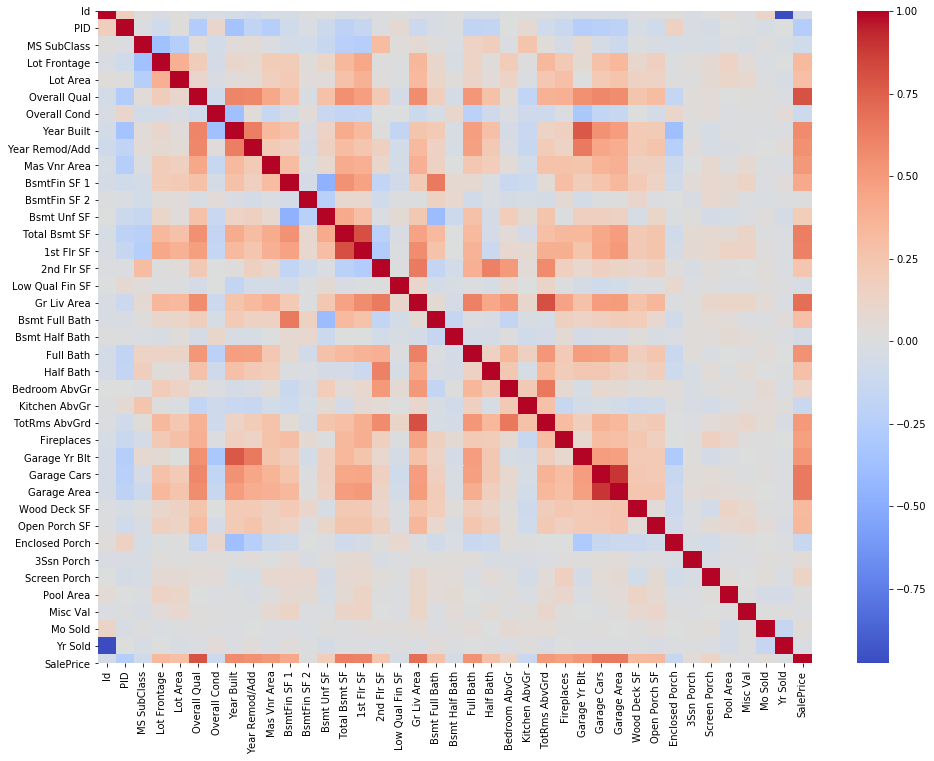

In [29]:
num_corr = numeric_data.corr()

fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
sns.heatmap(num_corr, cmap='coolwarm')

##### Here we want the bright deep colored squares since they are more correlated,
##### Especially among bottom row since that pertains to SalePrice.
##### We can obtain a sorted list of the most correlated with the code below

In [30]:
# I want it to print out nicely, therefore I'll toss into a DataFrame

high_corr = pd.DataFrame(num_corr['SalePrice'].sort_values(ascending=False))

### SalePrice Variable Correlation List (sorted)

In [31]:
high_corr

,SalePrice
SalePrice,1.000000
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650270
Garage Cars,0.648220
Total Bsmt SF,0.628925
1st Flr SF,0.618486
Year Built,0.571849
Year Remod/Add,0.550370
Full Bath,0.537969


In [32]:
# Looks like key correlated columns will be:

key_columns = ['Overall Qual',
               'Gr Liv Area',
               'Garage Area',
               'Garage Cars',
               'Total Bsmt SF',
               '1st Flr SF',
               'Year Built',
               'Year Remod/Add',
               'Full Bath',
               'Garage Yr Blt'
              ]

___


##### Housing Seasonality investigation - does it matter when we sell our home?

In [33]:
g = train2.groupby(['Yr Sold', 'Mo Sold']).Id.count()

Text(0.5, 1.0, 'House Sales Volume by Year and Month')

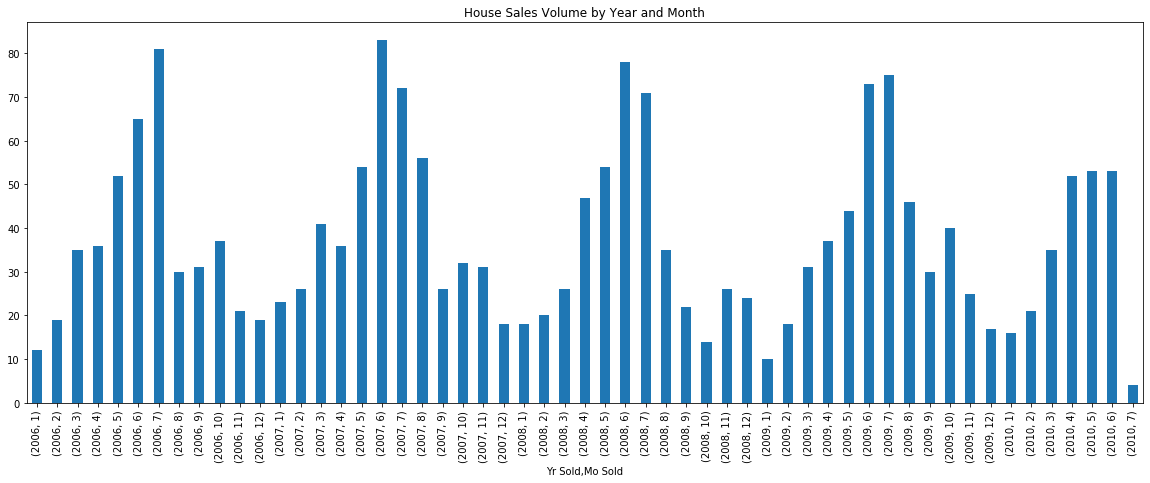

In [34]:
g.plot(kind='bar', figsize=(20,7))
plt.title("House Sales Volume by Year and Month")

##### Takeaway: June and July have higher sales volumes

---

#### Location is also important.  What impact will location (Neighborhood) have on sales price?

In [35]:
location1 = train2.groupby('Neighborhood').Id.count().sort_values(ascending=False)

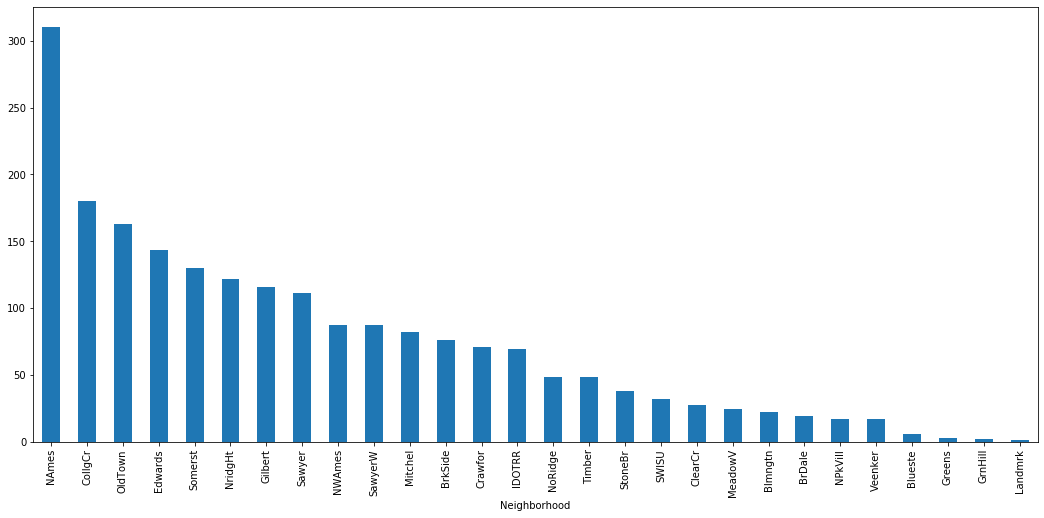

In [36]:
location1.plot(kind='bar', figsize = (18,8))
plt.title = ('Sales Counts by Neighborhood')

In [37]:
top_neighborhoods = location1.sort_values(ascending=False).head(10)

In [38]:
top_neighborhoods

Neighborhood
NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Name: Id, dtype: int64

##### Yes, there is a clear trend and neighborhood will indeed greatly influence SalePrice
___

### Next are there any Numerical columns that should really be categorical?

In [39]:
d = pd.melt(train2, value_vars = sorted(numeric_data))

<Figure size 1440x504 with 0 Axes>

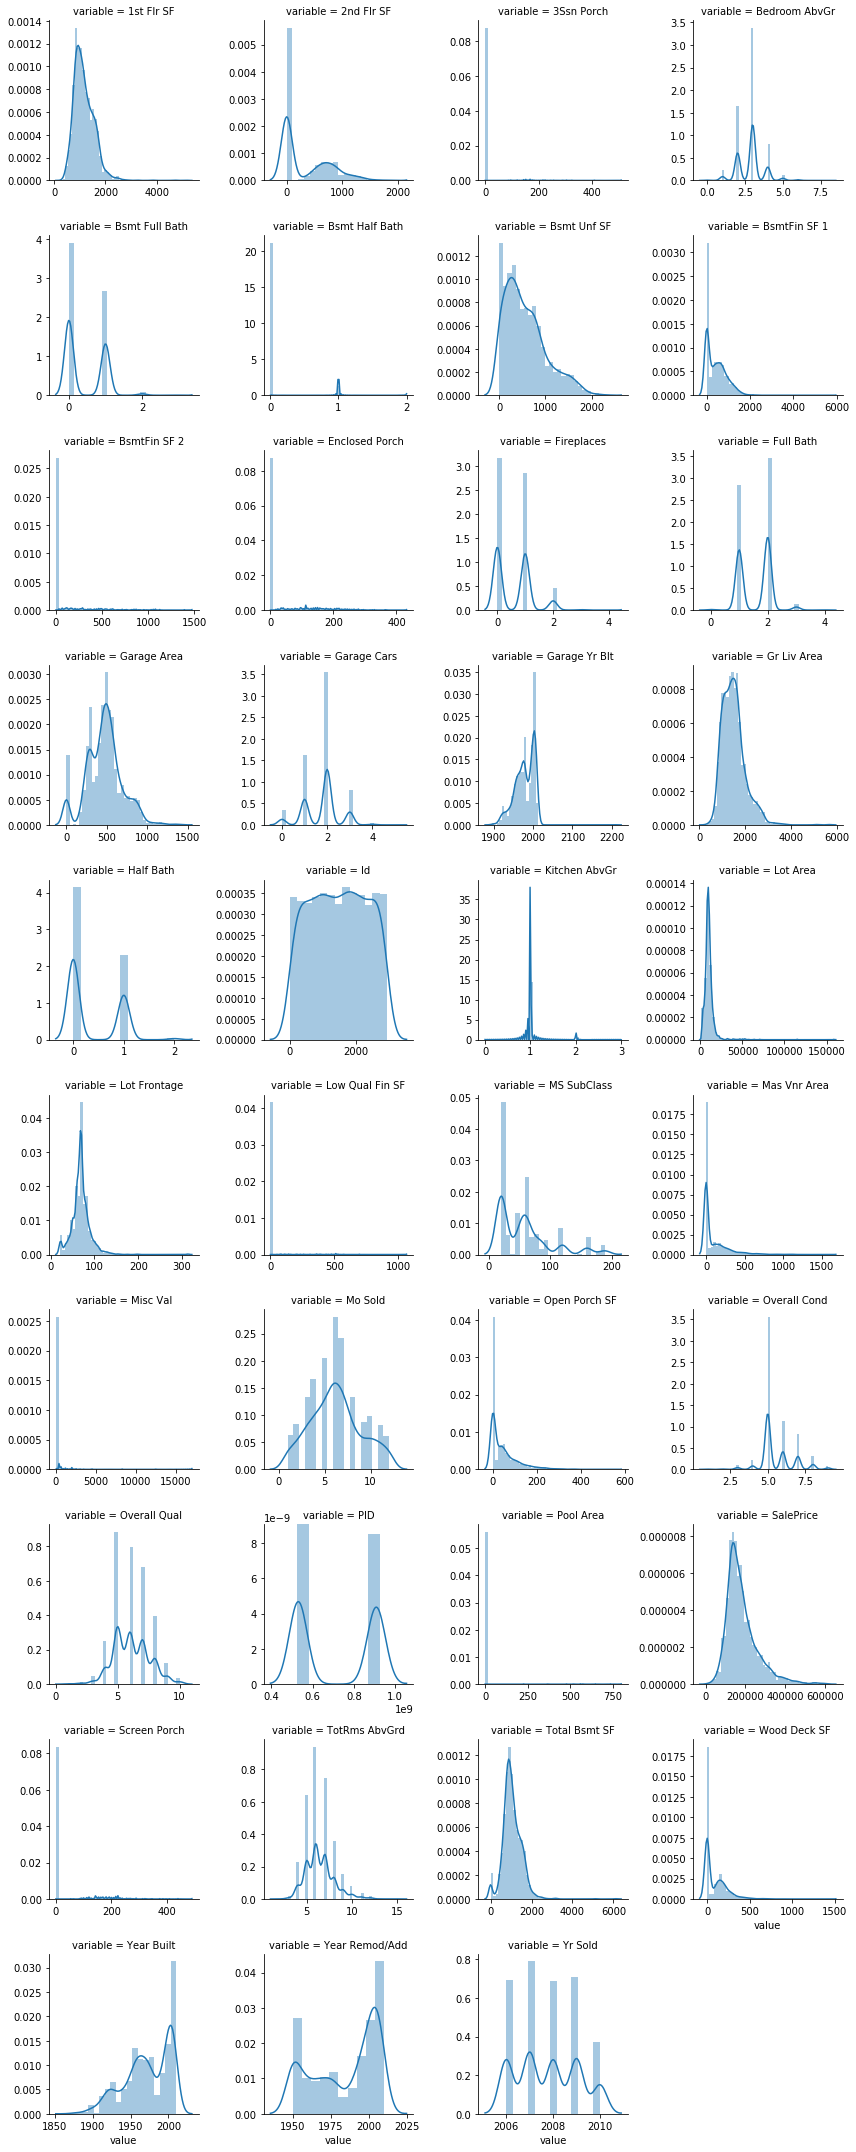

In [40]:
plt.figure(figsize = (20,7))
e = sns.FacetGrid(d, 
                 col = 'variable',
                 col_wrap=4,
                 sharex=False, sharey=False)
e = e.map(sns.distplot, 'value')
e.fig.tight_layout()

# # resources used:
#     # https://stackoverflow.com/questions/44466688/python-making-a-multipanel-bar-chart-with-different-categories-for-each-panel
#     # https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib/9827848#9827848

### A few numeric variables stand out as being better suited for categorical type.

### Fixing this will allow the model to learn better since these are NOT continuous values but rather discrete values

In [41]:
num_to_cat = list(['Bsmt Full Bath',
                 'Bsmt Half Bath',
                 'Fireplaces',
                  'Full Bath',
                  'Garage Cars',
                  'Half Bath',
                  'Low Qual Fin SF',
                  'MS SubClass',
                  'Mo Sold',
                  'Overall Cond',
                  'Overall Qual',
                  'PID',
                  'TotRms AbvGrd',
                  'Yr Sold',
                  'Year Remod/Add'])

In [42]:
# Converting numeric to string categorical data
# Resource used for apply code:
        # https://stackoverflow.com/questions/57097629/trouble-converting-strings-to-floats-in-pandas

train2['Bsmt Full Bath'] = train2['Bsmt Full Bath'].apply(lambda x: str(x))
train2['Bsmt Half Bath'] = train2['Bsmt Half Bath'].apply(lambda x: str(x))
train2['Fireplaces'] = train2['Fireplaces'].apply(lambda x: str(x))
train2['Bsmt Full Bath'] = train2['Bsmt Full Bath'].apply(lambda x: str(x))
train2['Full Bath'] = train2['Full Bath'].apply(lambda x: str(x))
train2['Garage Cars'] = train2['Garage Cars'].apply(lambda x: str(x))
train2['Half Bath'] = train2['Half Bath'].apply(lambda x: str(x))
train2['Low Qual Fin SF'] = train2['Low Qual Fin SF'].apply(lambda x: str(x))
train2['MS SubClass'] = train2['MS SubClass'].apply(lambda x: str(x))
train2['Mo Sold'] = train2['Mo Sold'].apply(lambda x: str(x))
train2['Overall Cond'] = train2['Overall Cond'].apply(lambda x: str(x))
train2['Overall Qual'] = train2['Overall Qual'].apply(lambda x: str(x))
train2['PID'] = train2['PID'].apply(lambda x: str(x))
train2['TotRms AbvGrd'] = train2['TotRms AbvGrd'].apply(lambda x: str(x))
train2['Yr Sold'] = train2['Yr Sold'].apply(lambda x: str(x))
train2['Year Remod/Add'] = train2['Year Remod/Add'].apply(lambda x: str(x))

In [43]:
# Check
train2['Yr Sold'].head()

0    2010
1    2009
2    2010
3    2010
4    2010
Name: Yr Sold, dtype: object

### Ok we've reviewed the numerical data, next let's review categorical/string variables

In [44]:
q = pd.melt(train2, value_vars = sorted(string_data))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1440x504 with 0 Axes>

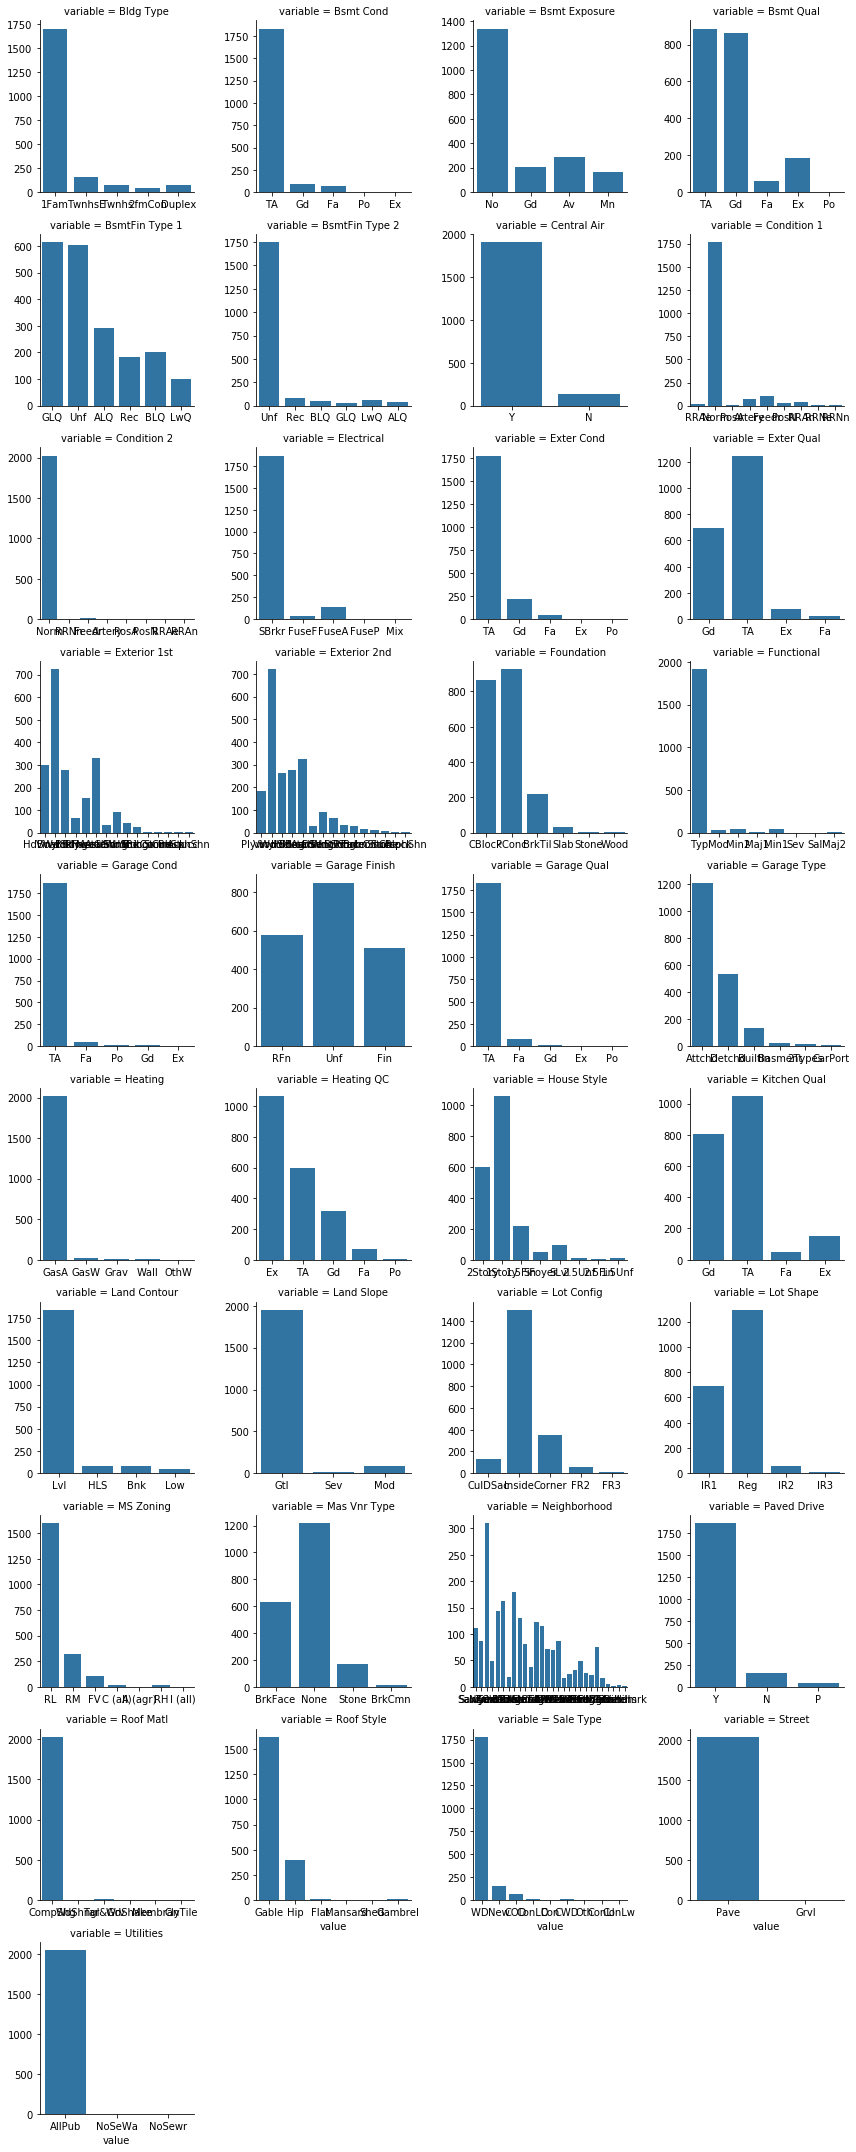

In [45]:
plt.figure(figsize = (20,7))
e = sns.FacetGrid(q,
                 col = 'variable',
                 col_wrap=4,
                 sharex=False, sharey=False)
e = e.map(sns.countplot, 'value')  # here we want to use COUNTplot not DISTplot, since these are categorical values
e.fig.tight_layout()

# resources used:
    # https://stackoverflow.com/questions/44466688/python-making-a-multipanel-bar-chart-with-different-categories-for-each-panel
    # https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib/9827848#9827848

In [46]:
# There are a few variables here that we will turn to dummy variables:

cat_to_num = ['Lot Shape',
             'Land Contour',
             'Utilities',
             'Land Slope',
             'Exter Qual',
             'Exter Cond',
             'Bsmt Qual',
             'Bsmt Cond',
             'Bsmt Exposure',
             'BsmtFin Type 1',
             'BsmtFin Type 2',
             'Heating QC',
              'Kitchen Qual',
              'Functional',
              'Garage Finish',
              'Garage Qual',
              'Garage Cond',
              'Paved Drive',
             ]

In [47]:
len(cat_to_num)

18

In [48]:
train2.shape

(2051, 77)

In [49]:
train2.dropna(inplace=True)
train2.shape

(1866, 77)

#### Wahahaha! No more missing values !

In [50]:
# Identifying Numerical columns

numeric_data = train2.select_dtypes(include = [np.number])

# resource used:
    # https://stackoverflow.com/questions/19900202/how-to-determine-whether-a-column-variable-is-numeric-or-not-in-pandas-numpy/38185759#38185759

# Identifying String columns

string_data = train2.select_dtypes(exclude = [np.number])

In [51]:
string_data.head()

,PID,MS SubClass,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Fireplaces,Garage Type,Garage Finish,Garage Cars,Garage Qual,Garage Cond,Paved Drive,Mo Sold,Yr Sold,Sale Type
0,533352170,60,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,...,0,Attchd,RFn,2.0,TA,TA,Y,3,2010,WD
1,531379050,60,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,...,1,Attchd,RFn,2.0,TA,TA,Y,4,2009,WD
2,535304180,20,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,Detchd,Unf,1.0,TA,TA,Y,1,2010,WD
3,916386060,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,...,0,BuiltIn,Fin,2.0,TA,TA,Y,4,2010,WD
4,906425045,50,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,...,0,Detchd,Unf,2.0,TA,TA,N,3,2010,WD


In [52]:
# print results

l = format(numeric_data.shape[1]) # store numeric in a variable
z = format(string_data.shape[1]) # store string col count in variable

print(f'There are {l} numeric and {z} columns in the training dataset')

There are 25 numeric and 52 columns in the training dataset


In [53]:
24 + 52

76

### Next I want to evaluate which variables have high variance when plotted against SalePrice and therefore are likely influencing SalePrice

In [54]:
f1 = pd.melt(train2, id_vars = ['SalePrice'], value_vars = sorted(string_data))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1440x504 with 0 Axes>

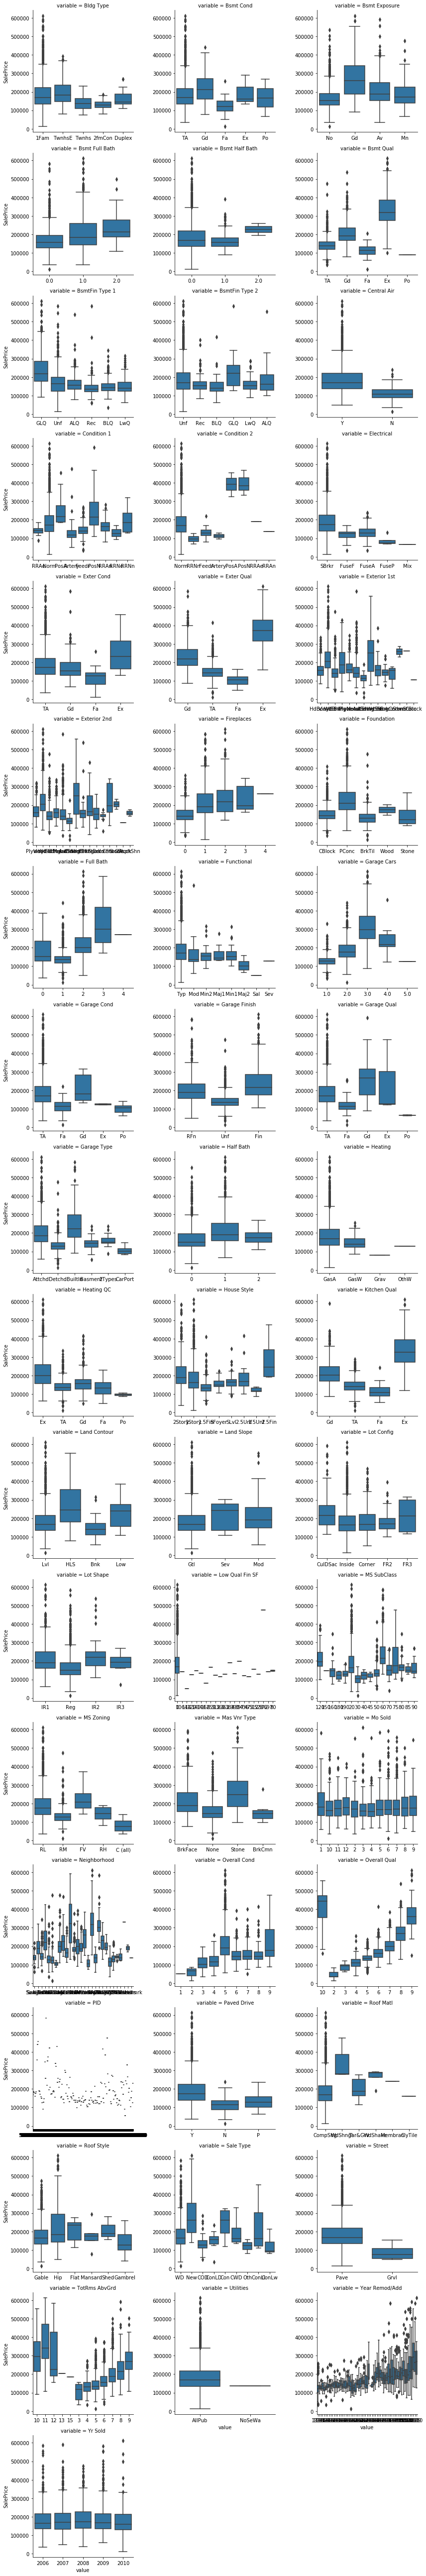

In [55]:
plt.figure(figsize = (20,7))
g1 = sns.FacetGrid(f1, col='variable', col_wrap=3, sharex=False, sharey = False, size = 4)
g1 = g1.map(sns.boxplot, 'value', 'SalePrice')
g1.fig.tight_layout()

# resources used:
    # https://stackoverflow.com/questions/44466688/python-making-a-multipanel-bar-chart-with-different-categories-for-each-panel
    # https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib/9827848#9827848

In [56]:
# Variables that visually stand out as having high variance and therefore likely greatly influence SalePrice include:

list2 = ['Neighborhood',
         'Condition 1',
         'Condition 2',
         'Exter Qual',
         'Fireplaces',
         'Full Bath',
         'Garage Cars',
         'MS SubClass',
         'Overall Cond',
         'Overall Qual',
         'TotRms AbvGrd',
         'Year Built',
         'Year Remod/Add',
         
]

In [57]:
# Interesting, so let's evaluate the variance. We can do that using ANOVA.

# General rule of thumb is that if p value is less than 0.05 then it is SIGNIFICANT
# null hypothesis: all features have same significance...must disprove this
        # we want a p value less than .05 to REJECT null hypothesis
    
# resource used:
    # https://stackoverflow.com/questions/3746225/mathematical-library-to-compare-simularities-in-graphs-of-data-for-a-high-level/3778749#3778749

In [58]:
cat_features = string_data.columns

In [59]:
# ANOVA time - objective is to obtain p-values to determine which variables are statistically significant

anova = {'feature':[], 'f':[], 'p':[]}

for cat in cat_features:
    group_prices = []
    for group in train2[cat].unique():
        group_prices.append(train2[train2[cat] == group]['SalePrice'].values)
        
    f, p = scipy.stats.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
    
anova = pd.DataFrame(anova)
anova = anova[['feature', 'f', 'p']]
anova.sort_values('p', inplace=True)

# resource used:
    # https://stackoverflow.com/questions/58990259/how-to-do-anova-with-three-categorical-variables
    # https://stackoverflow.com/questions/3746225/mathematical-library-to-compare-simularities-in-graphs-of-data-for-a-high-level/3778749#3778749
    

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3234: RuntimeWarning: divide by zero encountered in double_scalars
  msw = sswn / dfwn


In [60]:
anova.sort_values('p').head(25)

,feature,f,p
14,Overall Qual,512.054993,0.000000e+00
9,Neighborhood,87.688922,2.339593e-306
22,Exter Qual,657.739935,1.719351e-291
25,Bsmt Qual,461.637090,1.350941e-276
39,Kitchen Qual,607.900977,2.019356e-275
45,Garage Cars,452.369150,1.539019e-272
37,Full Bath,217.116251,5.031686e-153
40,TotRms AbvGrd,75.000932,1.403435e-139
44,Garage Finish,358.893404,1.432732e-132
24,Foundation,178.413618,1.730533e-129


In [61]:
# Interesting, these results help confirm hypothesis that
# Neighborhood (aka location), Exter Qual, Overall Qual are important factors influencing SalePrice

In [62]:
# check for duplicate records...
train2.duplicated('Id').sum()
test.duplicated('Id').sum()

0

In [63]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Neighborhood Feature Engineering

In [64]:
neigh_mean_price = train2.groupby(by='Neighborhood')['SalePrice'].mean()

In [65]:
neigh_mean_price.sort_values(ascending=False)

Neighborhood
GrnHill    330000.000000
StoneBr    329675.736842
NridgHt    321783.966387
NoRidge    316294.125000
Veenker    253570.588235
Timber     240492.872340
Somerst    226654.567797
ClearCr    221492.000000
Crawfor    205976.600000
CollgCr    203252.267045
Blmngtn    200417.681818
SawyerW    196133.243243
NWAmes     194619.022989
Gilbert    188947.618182
Greens     188666.666667
Mitchel    171711.333333
NAmes      148226.298969
Blueste    144566.666667
NPkVill    140476.470588
Sawyer     139190.307692
Landmrk    137000.000000
Edwards    136898.196078
BrkSide    134067.045455
SWISU      132754.962963
OldTown    129702.407143
IDOTRR     110797.191489
MeadowV    106391.176471
BrDale     104030.555556
Name: SalePrice, dtype: float64

In [66]:
neigh_mean_price.median()

188807.14242424243

In [67]:
# Median set at Gilbert then divide those sections by 2 in order to segment Neighborhoods and reduce multicollinearity

# Elite = StoneBr, NridgHt, NoRidge, Veenker, Timber, ClearCr, Somerst
# High = Crawfor, CollgCr, SawyerW, Blmngtn, Greens, NWAmes
# Medium = Gilbert, Mitchel, NAmes, Blueste, NPkVill, Sawyer
# Low = Edwards, BrkSide, SWISU, OldTown, IDOTRR, MeadowV, BrDale

In [68]:
# Instantiate new column for Neighborhood Ranking

train2['neigh_rank'] = "0"

In [69]:
train2['neigh_rank'].head()

0    0
1    0
2    0
3    0
4    0
Name: neigh_rank, dtype: object

In [70]:
neigh_dict = {'StoneBr':'3',
                          'NridgHt':'3',
                          'NoRidge':'3',
                          'Veenker':'3',
                          'Timber':'3',
                          'ClearCr':'3',
                          'Somerst':'3',
                          
                         'Crawfor':'2',
                          'CollgCr':'2',
                          'SawyerW':'2',
                          'Blmngtn':'2',
                          'Greens':'2',
                          'NWAmes':'2',
                          
                          'Gilbert':'1',
                          'Mitchel':'1',
                          'NAmes':'1',
                          'Blueste':'1',
                          'NPkVill':'1',
                          'Sawyer':'1',
                          
                          'Edwards':'0',
                          'BrkSide':'0',
                          'SWISU':'0',
                          'OldTown':'0',
                          'IDOTRR':'0',
                          'MeadowV':'0',
                          'BrDale':'0'}

In [71]:
train2['neigh_rank'] = train2['Neighborhood'].map(neigh_dict)

In [72]:
train2['neigh_rank'].tail()

2046    3
2047    0
2048    2
2049    1
2050    1
Name: neigh_rank, dtype: object

### Total Sq Ft Feature Engineering

In [73]:
# Total Sq Ft calc

train2['total_sq_ft'] = (train2['Total Bsmt SF']+
                         train2['Gr Liv Area'] +
                         train2['1st Flr SF'] +
                         train2['2nd Flr SF'] +
                         train2['Open Porch SF'] +
                         train2['Enclosed Porch'] +
                         train2['3Ssn Porch'] +
                         train2['Screen Porch'])

In [74]:
train2.shape

(1866, 79)

In [75]:
train2.dtypes

Id                   int64
PID                 object
MS SubClass         object
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual        object
Overall Cond        object
Year Built           int64
Year Remod/Add      object
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
BsmtFin SF 2       float64
B

### Additional Feature Engineering

In [76]:
# Let's create a few addl columns for features

train2['has_basement'] = train2['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
train2['has_garage'] = train2['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
train2['has_pool'] = train2['Pool Area'].apply(lambda x: 1 if x > 0 else 0)
train2['was_remodeled'] = (train2['Year Remod/Add'] != train2['Year Built']).astype(np.int64)
train2['is_new'] = (train2['Year Built']>=1996).astype(np.int64)

In [77]:
new_labels = ['has_basement',
             'has_garage',
             'has_pool',
             'was_remodeled',
             'is_new']

##### Additional cleaning

In [78]:
train2['MS Zoning'].value_counts()

RL         1478
RM          273
FV           93
C (all)      11
RH           11
Name: MS Zoning, dtype: int64

In [79]:
# remove low value MS Zoning records

train2 = train2[train2['MS Zoning']!='C (all)']

train2 = train2[train2['MS Zoning']!='RH']

In [80]:
numeric_data = train2.select_dtypes(include = [np.number])
string_data = train2.select_dtypes(exclude = [np.number])

l = format(numeric_data.shape[1]) # store numeric in a variable
z = format(string_data.shape[1]) # store string col count in variable

print(f'There are {l} numeric and {z} columns in the training dataset')

There are 31 numeric and 53 columns in the training dataset


In [81]:
30+52

82

In [82]:
num_features = numeric_data.columns
cat_features = string_data.columns

In [83]:
# Hone in on new labels within Numeric data only
num_features = [f for f in num_features if f not in new_labels]

#### Clean up some pesky lingering NaNs in Bath fields and add a Total Baths Variable

In [84]:
train2['Half Bath'] = train2['Half Bath'].astype(np.int64)

In [85]:
train2['Bsmt Half Bath'] = train2['Half Bath'].astype(np.int64)

In [86]:
train2['Full Bath'] = train2['Full Bath'].astype(np.int64)

In [87]:
train2['Bsmt Full Bath'].value_counts()

0.0    1041
1.0     782
2.0      21
Name: Bsmt Full Bath, dtype: int64

In [88]:
train2['Bsmt Full Bath'].value_counts()

0.0    1041
1.0     782
2.0      21
Name: Bsmt Full Bath, dtype: int64

In [89]:
# Add Total bathrooms field
train2['total_bathrooms'] = train2["Full Bath"] + (0.5 * train2['Half Bath']) + (0.5* train2['Bsmt Half Bath'])

# for some reason I couldn't add in the Bsmt Full Bath column....

In [90]:
# It's a string, so I'll force to Float
train2['Bsmt Full Bath'] = train2['Bsmt Full Bath'].astype(float)
train2['Bsmt Full Bath'].dtype

dtype('float64')

In [91]:
train2['total_bathrooms'] = train2['total_bathrooms'] + train2['Bsmt Full Bath']

In [92]:
train2['total_bathrooms'].head()

0    3.0
1    4.0
2    2.0
3    3.0
4    2.0
Name: total_bathrooms, dtype: float64

### Check for outliers (Gr Liv Area x SalePrice)

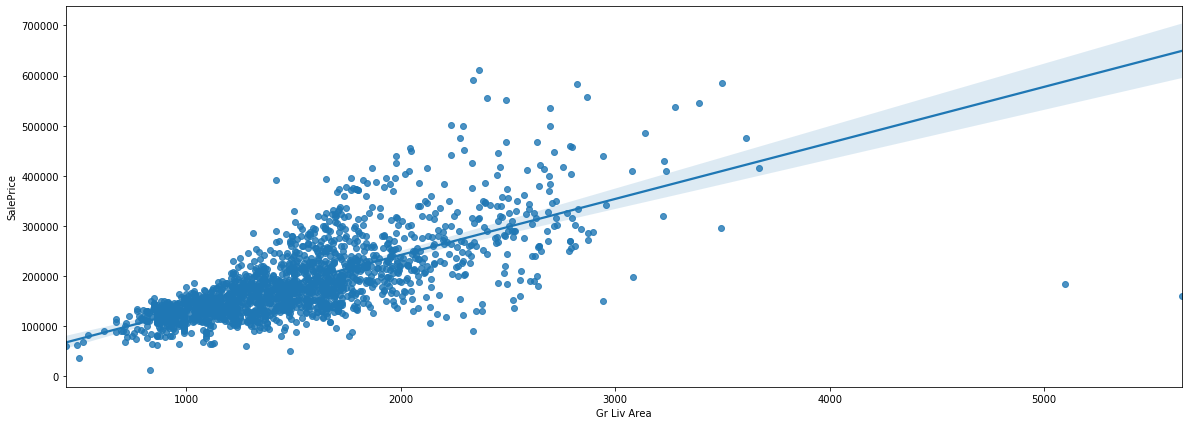

In [93]:
# check for outliers
# let's explore Gr Living Area vs saleprice since it had
# a high correlation and is the first highest variable that's numeric

plt.figure(figsize = (20,7))
sns.regplot(train2['Gr Liv Area'], train2.SalePrice)

In [94]:
# There's some outliers here.  Houses with 5K sq ft but low price !
# Most houses within 4K sq ft, so we can omit everything beyond it
# This will make the dataset better approximate a normal distribution

train2.drop(train2[train2['Gr Liv Area'] >= 4000].index, inplace=True)

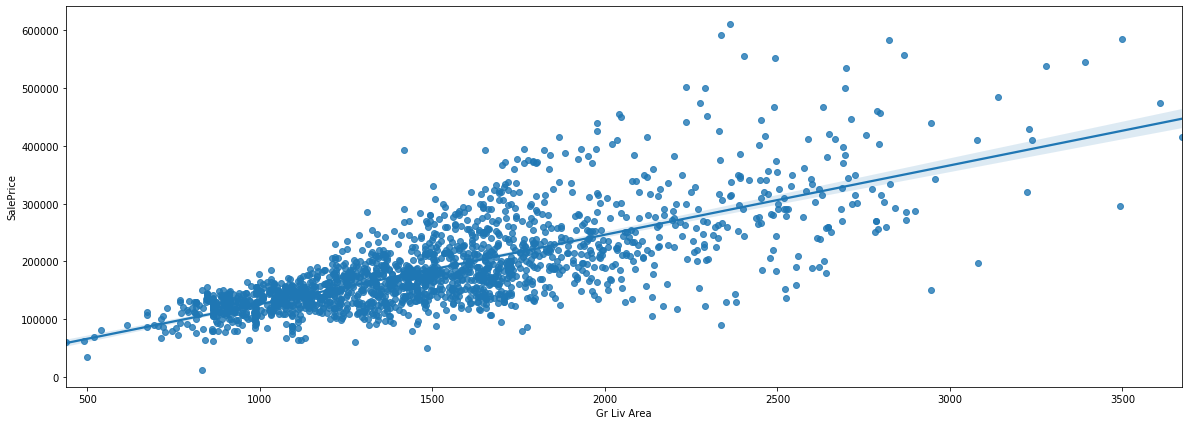

In [95]:
plt.figure(figsize = (20,7))
sns.regplot(train2['Gr Liv Area'], train2.SalePrice)

In [96]:
numeric_data = train2.select_dtypes(include = [np.number])
string_data = train2.select_dtypes(exclude = [np.number])

l = format(numeric_data.shape[1]) # store numeric in a variable
z = format(string_data.shape[1]) # store string col count in variable

print(f'There are {l} numeric and {z} columns in the training dataset')

num_features = numeric_data.columns
cat_features = string_data.columns

num_features = [f for f in num_features if f not in new_labels] # hone in on new numerical features only

There are 36 numeric and 49 columns in the training dataset


In [97]:
35 + 48

83

In [98]:
train2['has_garage'].head()

0    1
1    1
2    1
3    1
4    1
Name: has_garage, dtype: int64

### Features to hone in on

In [99]:
features = ['total_sq_ft',
            'age',
            'Lot Area',
            'BsmtFin SF 1',
            'is_new',
            'total_bathrooms',
            'has_garage',
            'was_remodeled',            
            
            'SalePrice'

]

In [100]:
train2.shape

(1842, 85)

### Contribute to SalePrice normal distribution by dropping low Sale Price

In [101]:
train2.drop(train2[train2['SalePrice'] < 50_000].index, inplace=True)

In [102]:
train2.shape

(1840, 85)

### Applying Log

In [103]:
for f in features:
    train2.loc[:,f] = np.log1p(train2[f])  # apply log in order to coerce and approximate normal distribution

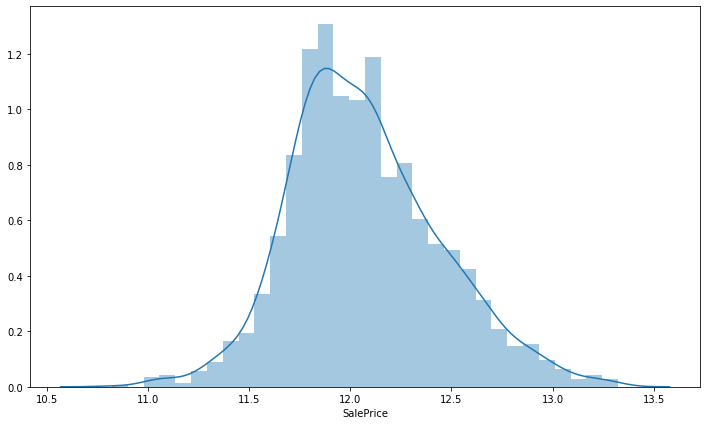

In [104]:
#### Checking SalePrice distribution approximates normal
plt.figure(figsize = (12,7))
sns.distplot(train2['SalePrice'])

In [105]:
y = train2['SalePrice']
train2.drop('SalePrice', axis=1, inplace=True)
train2.drop('Id',axis=1, inplace=True)
train2.drop('PID',axis=1,inplace=True)

In [106]:
train2.shape

(1840, 82)

In [107]:
model_data = pd.get_dummies(train2.copy())

In [108]:
model_data.head()

,Lot Frontage,Lot Area,Year Built,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Garage Yr Blt,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,age,total_sq_ft,has_basement,has_garage,has_pool,was_remodeled,is_new,total_bathrooms,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS Zoning_FV,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Overall Qual_10,Overall Qual_2,Overall Qual_3,Overall Qual_4,Overall Qual_5,Overall Qual_6,Overall Qual_7,Overall Qual_8,Overall Qual_9,Overall Cond_1,Overall Cond_2,Overall Cond_3,Overall Cond_4,Overall Cond_5,Overall Cond_6,Overall Cond_7,Overall Cond_8,Overall Cond_9,Year Remod/Add_1950,Year Remod/Add_1951,Year Remod/Add_1952,Year Remod/Add_1953,Year Remod/Add_1954,Year Remod/Add_1955,Year Remod/Add_1956,Year Remod/Add_1957,Year Remod/Add_1958,Year Remod/Add_1959,Year Remod/Add_1960,Year Remod/Add_1961,Year Remod/Add_1962,Year Remod/Add_1963,Year Remod/Add_1964,Year Remod/Add_1965,Year Remod/Add_1966,Year Remod/Add_1967,Year Remod/Add_1968,Year Remod/Add_1969,Year Remod/Add_1970,Year Remod/Add_1971,Year Remod/Add_1972,Year Remod/Add_1973,Year Remod/Add_1974,Year Remod/Add_1975,Year Remod/Add_1976,Year Remod/Add_1977,Year Remod/Add_1978,Year Remod/Add_1979,Year Remod/Add_1980,Year Remod/Add_1981,Year Remod/Add_1982,Year Remod/Add_1983,Year Remod/Add_1984,Year Remod/Add_1985,Year Remod/Add_1986,Year Remod/Add_1987,Year Remod/Add_1988,Year Remod/Add_1989,Year Remod/Add_1990,Year Remod/Add_1991,Year Remod/Add_1992,Year Remod/Add_1993,Year Remod/Add_1994,Year Remod/Add_1995,Year Remod/Add_1996,Year Remod/Add_1997,Year Remod/Add_1998,Year Remod/Add_1999,Year Remod/Add_2000,Year Remod/Add_2001,Year Remod/Add_2002,Year Remod/Add_2003,Year Remod/Add_2004,Year Remod/Add_2005,Year Remod/Add_2006,Year Remod/Add_2007,Year Remod/Add_2008,Year Remod/Add_2009,Year Remod/Add_2010,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsbShng,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Ex

In [109]:
model_data.shape

(1840, 413)

In [110]:
current_col = list(model_data.columns)

In [111]:
for i in missing_dummy_list:
    model_data[i] = 0

In [112]:
model_data.shape

(1840, 434)

### Prep Station

In [113]:
# Preparing Data to go through training

# y already defined as train2.SalePrice
X = model_data
y = y

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [115]:
print('Check Shapes:')
print('X_train:', X_train.shape)
print('X_val:', X_test.shape)
print('y_train:', y_train.shape)
print('y_val:', y_test.shape)

Check Shapes:
X_train: (1288, 434)
X_val: (552, 434)
y_train: (1288,)
y_val: (552,)


In [116]:
# Import StandardScaler.
from sklearn.preprocessing import StandardScaler as sc

# Instantiate Standard Scaler.
sc = StandardScaler()
# Fit AND transform Standard Scaler to overfit data in one step.
Z_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
Z_test = pd.DataFrame(sc.transform(X_test),columns=X_test.columns)

In [117]:
numeric_data = model_data.select_dtypes(include = [np.number])
string_data = model_data.select_dtypes(exclude = [np.number])

num_features = numeric_data.columns
cat_features = string_data.columns

Z_train = Z_train.loc[:,num_features]
Z_test = Z_test.loc[:,num_features]

In [120]:
from sklearn.model_selection import cross_val_score

def rsme(model, X, y):
    cv_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=10)
    return np.sqrt(cv_scores)

In [121]:
# LASSO TIME!
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 25.],
              'max_iter': [50000]}

lasso = GridSearchCV(Lasso(),
                     cv=5,
                     n_jobs=-1,
                     param_grid=param_grid,
                     scoring='neg_mean_squared_error')

lasso.fit(Z_train, y_train)

alpha = lasso.best_params_['alpha']


# LASER FOCUS ON IMPORTANT VARIABLES ONLY!

param_grid = {'alpha': [x/100. * alpha for x in range (50, 150, 5)],
              'max_iter': [50000]}

lasso = GridSearchCV(Lasso(),
                     cv=5,
                     n_jobs=-1,
                     param_grid=param_grid,
                     scoring='neg_mean_squared_error')

lasso.fit(Z_train, y_train)

alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

print('Lasso --> Train RSME: {:.5f} | Test RSME: {:.5f} | alpha: {:.5f}'.format(rsme(lasso, Z_train, y_train).mean(), rsme(lasso, Z_test, y_test).mean(), alpha))

# resources used:
    # https://www.youtube.com/watch?v=0yI0-r3Ly40
    # https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624
    # https://elvinouyang.github.io/study%20notes/python-linear-models-for-continuous-target/
    # https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/
    # https://medium.com/hanman/data-modeling-building-a-house-price-prediction-model-1450f825073b

Lasso --> Train RSME: 0.11253 | Test RSME: 0.10546 | alpha: 0.00145


LASSO dropped 308 of 434 features.


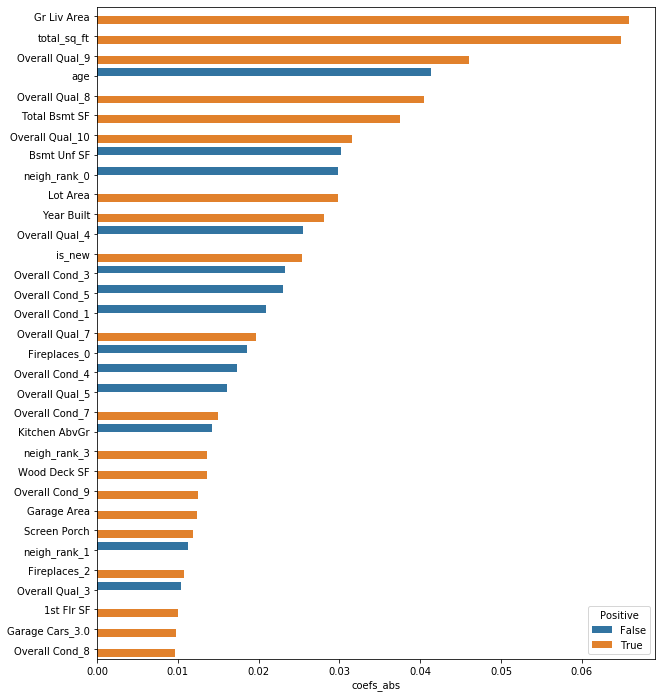

In [122]:
# Visual

coefs = pd.DataFrame({'coefs':lasso.coef_,
                      'Positive': lasso.coef_ > 0},
                     index= Z_train.columns)

coefs['coefs_abs'] = np.abs(coefs.coefs)

print('LASSO dropped {} of {} features.'.format(sum(coefs.coefs ==0),
                                                coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs',
                              ascending=False).head(33)
plt.figure(figsize=(10,12))

sns.barplot(top_coefs.coefs_abs,
            top_coefs.index,
            orient='h',
            hue=top_coefs.Positive)

# resources used:
    # https://methodmatters.github.io/analyzing-wine-data-in-python-part-1/
    # https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/
    # https://medium.com/hanman/data-modeling-building-a-house-price-prediction-model-1450f825073b

In [124]:
top_coefs

,coefs,Positive,coefs_abs
Gr Liv Area,0.065765,True,0.065765
total_sq_ft,0.064895,True,0.064895
Overall Qual_9,0.046034,True,0.046034
age,-0.041297,False,0.041297
Overall Qual_8,0.040396,True,0.040396
Total Bsmt SF,0.037524,True,0.037524
Overall Qual_10,0.031490,True,0.031490
Bsmt Unf SF,-0.030247,False,0.030247
neigh_rank_0,-0.029838,False,0.029838
Lot Area,0.029831,True,0.029831


In [125]:
lasso.score(Z_train, y_train)

0.9293842320711352

In [126]:
lasso.score(Z_test, y_test)

0.9269933362871265

In [127]:
# Test score is lower than Train score
# This means there's too many features in Train and that
# I should remove some!

In [128]:
top_coefs

,coefs,Positive,coefs_abs
Gr Liv Area,0.065765,True,0.065765
total_sq_ft,0.064895,True,0.064895
Overall Qual_9,0.046034,True,0.046034
age,-0.041297,False,0.041297
Overall Qual_8,0.040396,True,0.040396
Total Bsmt SF,0.037524,True,0.037524
Overall Qual_10,0.031490,True,0.031490
Bsmt Unf SF,-0.030247,False,0.030247
neigh_rank_0,-0.029838,False,0.029838
Lot Area,0.029831,True,0.029831


### Linear Regression

In [129]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(Z_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [130]:
y_pred = lr_model.predict(Z_train)

In [131]:
# print("Predicted Value: " + str(lr_model.predict([Z_test[10]])))
# print("Real Value: " + str(y_test[10]))

In [132]:
print("Accuracy ---> ", lr_model.score(Z_test, y_test)*100)

Accuracy --->  -1.3202467583779755e+26


In [133]:
from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [134]:
# rmse(y,y_pred)  # do rmse on entire y value, not the subset !

In [135]:
cross_val_score(lr_model, X, y, cv=5).mean()

-1481741095854.7603

In [136]:
# Score the model with the training data
lr_model.score(Z_train, y_train)

0.9325773545390784

In [137]:
# Score the model with the test data
lr_model.score(Z_test, y_test)
# usually want to see a similar score with train and test scores
# test score better than train score means it needs more features, train is bias, test is variance
# test score lower than train score means there's too many features, take some out !

-1.3202467583779755e+24

---

### Test dataset cleaning

In [138]:
# Next step is to do same steps to test_csv dataset (remember no deleting rows)

In [139]:
t2 = test

In [140]:
t2.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [141]:
# Identify missing values in test dataset and sort

(t2.isna().sum()).sort_values(ascending=False).head(30)

Pool QC           874
Misc Feature      837
Alley             820
Fence             706
Fireplace Qu      422
Lot Frontage      160
Garage Cond        45
Garage Qual        45
Garage Yr Blt      45
Garage Finish      45
Garage Type        44
Bsmt Exposure      25
BsmtFin Type 1     25
Bsmt Qual          25
BsmtFin Type 2     25
Bsmt Cond          25
Mas Vnr Area        1
Mas Vnr Type        1
Electrical          1
Overall Cond        0
Exter Qual          0
Exter Cond          0
Foundation          0
Exterior 2nd        0
Exterior 1st        0
Roof Matl           0
Roof Style          0
Year Remod/Add      0
Year Built          0
Sale Type           0
dtype: int64

In [142]:
t2.shape # only 878 rows, therefore anything above 400 missing rows will have over 50% missing haha

(878, 80)

In [143]:
t2.drop(t2[['Pool QC', 'Misc Feature', 'Alley','Fence', 'Fireplace Qu']],axis=1, inplace=True)

In [144]:
# Add age column

t2['age'] = t2['Yr Sold'] - t2['Year Built']

In [145]:
# Converting numeric to string categorical data
# Resource used for apply code:
        # https://stackoverflow.com/questions/57097629/trouble-converting-strings-to-floats-in-pandas

t2['Bsmt Full Bath'] = t2['Bsmt Full Bath'].apply(lambda x: str(x))
t2['Bsmt Half Bath'] = t2['Bsmt Half Bath'].apply(lambda x: str(x))
t2['Fireplaces'] = t2['Fireplaces'].apply(lambda x: str(x))
t2['Bsmt Full Bath'] = t2['Bsmt Full Bath'].apply(lambda x: str(x))
t2['Full Bath'] = t2['Full Bath'].apply(lambda x: str(x))
t2['Garage Cars'] = t2['Garage Cars'].apply(lambda x: str(x))
t2['Half Bath'] = t2['Half Bath'].apply(lambda x: str(x))
t2['Low Qual Fin SF'] = t2['Low Qual Fin SF'].apply(lambda x: str(x))
t2['MS SubClass'] = t2['MS SubClass'].apply(lambda x: str(x))
t2['Mo Sold'] = t2['Mo Sold'].apply(lambda x: str(x))
t2['Overall Cond'] = t2['Overall Cond'].apply(lambda x: str(x))
t2['Overall Qual'] = t2['Overall Qual'].apply(lambda x: str(x))
t2['PID'] = t2['PID'].apply(lambda x: str(x))
t2['TotRms AbvGrd'] = t2['TotRms AbvGrd'].apply(lambda x: str(x))
t2['Yr Sold'] = t2['Yr Sold'].apply(lambda x: str(x))
t2['Year Remod/Add'] = t2['Year Remod/Add'].apply(lambda x: str(x))

In [146]:
t2.isna().sum().sort_values(ascending=False).head(15)

Lot Frontage      160
Garage Cond        45
Garage Qual        45
Garage Yr Blt      45
Garage Finish      45
Garage Type        44
BsmtFin Type 1     25
BsmtFin Type 2     25
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
Electrical          1
Mas Vnr Area        1
Mas Vnr Type        1
Exter Qual          0
dtype: int64

In [147]:
na_list = ['Lot Frontage',
          'Garage Qual',
          'Garage Cond',
          'Garage Yr Blt',
          'Garage Finish',
          'Garage Type',
          'BsmtFin Type 1',
          'Bsmt Exposure',
          'Bsmt Qual',
          'Bsmt Cond',
          'BsmtFin Type 2',
          'Mas Vnr Area',
          'Electrical',
          'Mas Vnr Type']

In [148]:
t2[na_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Frontage    718 non-null    float64
 1   Garage Qual     833 non-null    object 
 2   Garage Cond     833 non-null    object 
 3   Garage Yr Blt   833 non-null    float64
 4   Garage Finish   833 non-null    object 
 5   Garage Type     834 non-null    object 
 6   BsmtFin Type 1  853 non-null    object 
 7   Bsmt Exposure   853 non-null    object 
 8   Bsmt Qual       853 non-null    object 
 9   Bsmt Cond       853 non-null    object 
 10  BsmtFin Type 2  853 non-null    object 
 11  Mas Vnr Area    877 non-null    float64
 12  Electrical      877 non-null    object 
 13  Mas Vnr Type    877 non-null    object 
dtypes: float64(3), object(11)
memory usage: 96.2+ KB


In [149]:
num_nan_list = ['Lot Frontage', 'Garage Yr Blt', 'Mas Vnr Area']
str_nan_list = ['Garage Qual',
          'Garage Cond',
          'Garage Finish',
          'Garage Type',
          'BsmtFin Type 1',
          'Bsmt Exposure',
          'Bsmt Qual',
          'Bsmt Cond',
          'BsmtFin Type 2',
          'Electrical',
          'Mas Vnr Type']

In [150]:
for col in num_nan_list:
    print([col, t2[col].mean()])

['Lot Frontage', 69.54596100278552]
['Garage Yr Blt', 1976.7599039615845]
['Mas Vnr Area', 106.23603192702394]


In [151]:
t2['Lot Frontage'].fillna(69.55,inplace=True)
t2['Garage Yr Blt'].fillna(1976,inplace=True)
t2['Mas Vnr Area'].fillna(106,inplace=True)

In [152]:
for col in str_nan_list:
    t2[col].replace(np.nan,0,inplace=True)
    print("All set")

All set
All set
All set
All set
All set
All set
All set
All set
All set
All set
All set


In [153]:
t2.isnull().sum().sort_values(ascending=False).head()

age               0
Exter Qual        0
Year Remod/Add    0
Roof Style        0
Roof Matl         0
dtype: int64

In [154]:
# WOOO No NANs or missing values !

In [155]:
# Instantiate new column for Neighborhood Ranking

t2['neigh_rank'] = "0"

t2['neigh_rank'] = t2['Neighborhood'].map(neigh_dict)

In [156]:
# Total Sq Ft calc

t2['total_sq_ft'] = (t2['Total Bsmt SF']+
                         t2['Gr Liv Area'] +
                         t2['1st Flr SF'] +
                         t2['2nd Flr SF'] +
                         t2['Open Porch SF'] +
                         t2['Enclosed Porch'] +
                         t2['3Ssn Porch'] +
                         t2['Screen Porch'])

In [157]:
t2['has_basement'] = t2['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
t2['has_garage'] = t2['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
t2['has_pool'] = t2['Pool Area'].apply(lambda x: 1 if x > 0 else 0)
t2['was_remodeled'] = (t2['Year Remod/Add'] != t2['Year Built']).astype(np.int64)
t2['is_new'] = (t2['Year Built']>=1996).astype(np.int64)

In [158]:
t2['Half Bath'] = t2['Half Bath'].astype(np.int64)
t2['Bsmt Half Bath'] = t2['Half Bath'].astype(np.int64)
t2['Full Bath'] = t2['Full Bath'].astype(np.int64)
t2['total_bathrooms'] = t2["Full Bath"] + (0.5 * t2['Half Bath']) + (0.5* t2['Bsmt Half Bath'])
t2['Bsmt Full Bath'] = t2['Bsmt Full Bath'].astype(float)
t2['total_bathrooms'] = t2['total_bathrooms'] + t2['Bsmt Full Bath']

In [159]:
t2.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,age,neigh_rank,total_sq_ft,has_basement,has_garage,has_pool,was_remodeled,is_new,total_bathrooms
0,2658,902301120,190,RM,69.00,9142,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0.0,0,2,0,4,2,Fa,9,Typ,0,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,0,4,2006,WD,96,0,5048,1,1,0,1,0,2.0
1,2718,905108090,90,RL,69.55,9662,Pave,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0.0,0,2,0,6,2,TA,10,Typ,0,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,0,8,2006,WD,29,1,5901,1,1,0,1,0,2.0
2,2414,528218130,60,RL,58.00,17104,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1.0,1,2,1,3,1,Gd,7,Typ,1,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,0,9,2006,New,0,1,3670,1,1,0,1,1,4.0
3,1989,902207150,30,RM,60.00,8520,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0.0,0,1,0,2,1,TA,5,Typ,0,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,0,7,2007,WD,84,0,3088,1,1,0,1,0,1.0
4,625,535105100,20,RL,69.55,9500,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1.0,1,1,1,3,1,TA,6,Typ,2,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,0,7,2009,WD,46,1,4443,1,1,0,1,0,3.0


In [160]:
numeric_data = t2.select_dtypes(include = [np.number])
num_features = numeric_data.columns

In [161]:
features = ['total_sq_ft',
            'age',
            'Lot Area',
            'BsmtFin SF 1',
            'is_new',
            'total_bathrooms',
            'has_garage',
            'was_remodeled'
]

In [162]:
for f in features:
    t2.loc[:,f] = np.log1p(t2[f])  # apply log in order to coerce and approximate normal distribution

In [163]:
t2_model_data = pd.get_dummies(t2.copy())

In [164]:
t2_model_data.head()

,Id,Lot Frontage,Lot Area,Year Built,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Garage Yr Blt,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,age,total_sq_ft,has_basement,has_garage,has_pool,was_remodeled,is_new,total_bathrooms,PID_1007100110,PID_526302110,PID_526302120,PID_526350040,PID_526351100,PID_526353030,PID_526353050,PID_527105030,PID_527106010,PID_527106150,PID_527107030,PID_527107120,PID_527107130,PID_527107240,PID_527108040,PID_527108060,PID_527108090,PID_527110080,PID_527127100,PID_527127150,PID_527131110,PID_527132090,PID_527161090,PID_527162080,PID_527163020,PID_527163070,PID_527163130,PID_527164020,PID_527164120,PID_527165010,PID_527165020,PID_527182170,PID_527183030,PID_527216010,PID_527225035,PID_527226020,PID_527252090,PID_527254020,PID_527254070,PID_527256120,PID_527258010,PID_527258020,PID_527301280,PID_527302210,PID_527325090,PID_527325160,PID_527325240,PID_527326040,PID_527327080,PID_527328010,PID_527328020,PID_527328050,PID_527353060,PID_527356050,PID_527357110,PID_527358200,PID_527359030,PID_527359180,PID_527365010,PID_527366030,PID_527368010,PID_527375210,PID_527376100,PID_527376110,PID_527377110,PID_527378010,PID_527378020,PID_527402060,PID_527402210,PID_527402380,PID_527403040,PID_527403120,PID_527404030,PID_527404100,PID_527404120,PID_527404150,PID_527405130,PID_527425060,PID_527425140,PID_527427090,PID_527427160,PID_527450080,PID_527450150,PID_527450210,PID_527450220,PID_527450520,PID_527451020,PID_527451110,PID_527451330,PID_527451380,PID_527451520,PID_527451650,PID_527452060,PID_527452150,PID_527452310,PID_527453050,PID_527454200,PID_527455090,PID_527455100,PID_527455270,PID_528102050,PID_528102140,PID_528106050,PID_528106060,PID_528106120,PID_528108020,PID_528108140,PID_528108150,PID_528110020,PID_528110040,PID_528118010,PID_528118030,PID_528118060,PID_528120020,PID_528120060,PID_528120090,PID_528120120,PID_528120130,PID_528138010,PID_528138030,PID_528142070,PID_528142110,PID_528144020,PID_528144030,PID_528150090,PID_528150120,PID_528164060,PID_528168040,PID_528170040,PID_528172020,PID_528174020,PID_528174030,PID_528175010,PID_528180120,PID_528180130,PID_528181040,PID_528181070,PID_528181080,PID_528186120,PID_528186170,PID_528186190,PID_528188060,PID_528218030,PID_528218050,PID_528218090,PID_528218100,PID_528218130,PID_528221040,PID_528221060,PID_528221070,PID_528222010,PID_528222020,PID_528222040,PID_528228285,PID_528228345,PID_528228415,PID_528228460,PID_528228550,PID_528228580,PID_528231010,PID_528231030,PID_528235000,PID_528235160,PID_528240150,PID_528250020,PID_528250100,PID_528253010,PID_528253020,PID_528280100,PID_528280130,PID_528290010,PID_528290120,PID_528292040,PID_528292080,PID_528294010,PID_528294050,PID_528294070,PID_528315060,PID_528320050,PID_528320060,PID_528322020,PID_528326030,PID_528327010,PID_528344070,PID_528344100,PID_528346050,PID_528351010,PID_528354050,PID_528354060,PID_528354110,PID_528363050,PID_528363070,PID_528385050,PID_528387050,PID_528390210,PID_528427040,PID_528427070,PID_528429050,PID_528429070,PID_528429120,PID_528429130,PID_528431020,PID_528431040,PID_528431060,PID_528431080,PID_528435020,PID_528435040,PID_528435050,PID_528445020,PID_528456180,PID_528458030,PID_528458040,PID_528458050,PID_528458120,PID_528458140,PID_528477010,PID_528478030,PID_528480090,PID_528480100,PID_528480150,PID_528482130,PID_528490040,PID_531363010,PID_531375040,PID_531375060,PID_531375090,PID_531375120,PID_531379030,PID_531382120,PID_531384070,PID_531385060,PID_531385130,PID_531450030,PID_531450040,PID_531450170,PID_531451020,PID_531452050,PID_531452100,PID_531452140,PID_531452180,PID_531453040,PID_531453100,PID_531453140,PID_531475220,PID_531477040,PID_531477050,PID_531479020,PID_531479030,PID_532351050,PID_532351150,PID_532353020,PID_532353130,PID_532354070,PID_532354090,PID_532354160,PID_532376040,PID_

In [165]:
#test
t2_model_data.shape

(878, 1284)

In [166]:
# Fit AND transform Standard Scaler to overfit data in one step.
t2_model_data = pd.DataFrame(sc.fit_transform(t2_model_data), columns=t2_model_data.columns)

In [167]:
t2_model_data.head()

,Id,Lot Frontage,Lot Area,Year Built,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Garage Yr Blt,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,age,total_sq_ft,has_basement,has_garage,has_pool,was_remodeled,is_new,total_bathrooms,PID_1007100110,PID_526302110,PID_526302120,PID_526350040,PID_526351100,PID_526353030,PID_526353050,PID_527105030,PID_527106010,PID_527106150,PID_527107030,PID_527107120,PID_527107130,PID_527107240,PID_527108040,PID_527108060,PID_527108090,PID_527110080,PID_527127100,PID_527127150,PID_527131110,PID_527132090,PID_527161090,PID_527162080,PID_527163020,PID_527163070,PID_527163130,PID_527164020,PID_527164120,PID_527165010,PID_527165020,PID_527182170,PID_527183030,PID_527216010,PID_527225035,PID_527226020,PID_527252090,PID_527254020,PID_527254070,PID_527256120,PID_527258010,PID_527258020,PID_527301280,PID_527302210,PID_527325090,PID_527325160,PID_527325240,PID_527326040,PID_527327080,PID_527328010,PID_527328020,PID_527328050,PID_527353060,PID_527356050,PID_527357110,PID_527358200,PID_527359030,PID_527359180,PID_527365010,PID_527366030,PID_527368010,PID_527375210,PID_527376100,PID_527376110,PID_527377110,PID_527378010,PID_527378020,PID_527402060,PID_527402210,PID_527402380,PID_527403040,PID_527403120,PID_527404030,PID_527404100,PID_527404120,PID_527404150,PID_527405130,PID_527425060,PID_527425140,PID_527427090,PID_527427160,PID_527450080,PID_527450150,PID_527450210,PID_527450220,PID_527450520,PID_527451020,PID_527451110,PID_527451330,PID_527451380,PID_527451520,PID_527451650,PID_527452060,PID_527452150,PID_527452310,PID_527453050,PID_527454200,PID_527455090,PID_527455100,PID_527455270,PID_528102050,PID_528102140,PID_528106050,PID_528106060,PID_528106120,PID_528108020,PID_528108140,PID_528108150,PID_528110020,PID_528110040,PID_528118010,PID_528118030,PID_528118060,PID_528120020,PID_528120060,PID_528120090,PID_528120120,PID_528120130,PID_528138010,PID_528138030,PID_528142070,PID_528142110,PID_528144020,PID_528144030,PID_528150090,PID_528150120,PID_528164060,PID_528168040,PID_528170040,PID_528172020,PID_528174020,PID_528174030,PID_528175010,PID_528180120,PID_528180130,PID_528181040,PID_528181070,PID_528181080,PID_528186120,PID_528186170,PID_528186190,PID_528188060,PID_528218030,PID_528218050,PID_528218090,PID_528218100,PID_528218130,PID_528221040,PID_528221060,PID_528221070,PID_528222010,PID_528222020,PID_528222040,PID_528228285,PID_528228345,PID_528228415,PID_528228460,PID_528228550,PID_528228580,PID_528231010,PID_528231030,PID_528235000,PID_528235160,PID_528240150,PID_528250020,PID_528250100,PID_528253010,PID_528253020,PID_528280100,PID_528280130,PID_528290010,PID_528290120,PID_528292040,PID_528292080,PID_528294010,PID_528294050,PID_528294070,PID_528315060,PID_528320050,PID_528320060,PID_528322020,PID_528326030,PID_528327010,PID_528344070,PID_528344100,PID_528346050,PID_528351010,PID_528354050,PID_528354060,PID_528354110,PID_528363050,PID_528363070,PID_528385050,PID_528387050,PID_528390210,PID_528427040,PID_528427070,PID_528429050,PID_528429070,PID_528429120,PID_528429130,PID_528431020,PID_528431040,PID_528431060,PID_528431080,PID_528435020,PID_528435040,PID_528435050,PID_528445020,PID_528456180,PID_528458030,PID_528458040,PID_528458050,PID_528458120,PID_528458140,PID_528477010,PID_528478030,PID_528480090,PID_528480100,PID_528480150,PID_528482130,PID_528490040,PID_531363010,PID_531375040,PID_531375060,PID_531375090,PID_531375120,PID_531379030,PID_531382120,PID_531384070,PID_531385060,PID_531385130,PID_531450030,PID_531450040,PID_531450170,PID_531451020,PID_531452050,PID_531452100,PID_531452140,PID_531452180,PID_531453040,PID_531453100,PID_531453140,PID_531475220,PID_531477040,PID_531477050,PID_531479020,PID_531479030,PID_532351050,PID_532351150,PID_532353020,PID_532353130,PID_532354070,PID_532354090,PID_532354160,PID_532376040,PID_

In [168]:
# train
model_data.shape

(1840, 434)

In [169]:
# make a set to finalize column alignment

train_col = model_data.columns
test_col = t2_model_data.columns

In [170]:
missing_list2 = set(train_col)-set(test_col)

In [171]:
for i in missing_list2:
    t2_model_data[i] = 0
    print("All set!")

All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!
All set!


In [172]:
t2_model_data.shape, model_data.shape

((878, 1334), (1840, 434))

In [173]:
t2_model_data[model_data.columns].shape

(878, 434)

In [174]:
t3 = t2_model_data[model_data.columns] # filter out unneeded columns

In [175]:
# ensure shapes align!
t3.shape, model_data.shape

((878, 434), (1840, 434))

In [176]:
y_preds = lasso.predict(t3)

In [177]:
# take out LOG!
y_preds = np.exp(y_preds)

### Output Station

In [178]:
output=pd.DataFrame()

In [179]:
output['Id'] = t_id

In [180]:
output['SalePrice'] = y_preds

In [181]:
output.shape

(878, 2)

In [182]:
output.head(7)

,Id,SalePrice
0,2658,138585.516853
1,2718,149179.750065
2,2414,215510.321121
3,1989,116366.168223
4,625,181502.048112
5,333,102499.214800
6,1327,118938.867184


In [184]:
output.to_csv('./output/output.csv', index=False)
# don't include index for submission

In [185]:
# Check to ensure file was successfully created
check = pd.read_csv('./output/output.csv')
check.head(7)

,Id,SalePrice
0,2658,138585.516853
1,2718,149179.750065
2,2414,215510.321121
3,1989,116366.168223
4,625,181502.048112
5,333,102499.214800
6,1327,118938.867184


In [186]:
check.shape

(878, 2)